# IMPORT DATA

In [0]:
# import libraries
import requests
import gzip
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import math

In [0]:
# Assing URL to variable
url_images_train = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
url_labels_train = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
url_images_test = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
url_labels_test = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'

In [3]:
# download and write files 
url_images_train_req = requests.get(url_images_train)
url_labels_train_req = requests.get(url_labels_train)
url_images_test_req = requests.get(url_images_test)
url_labels_test_req = requests.get(url_labels_test)
open('images_train.gz', 'wb').write(url_images_train_req.content)
open('labels_train.gz', 'wb').write(url_labels_train_req.content)
open('images_test.gz', 'wb').write(url_images_test_req.content)
open('labels_test.gz', 'wb').write(url_labels_test_req.content)

4542

In [0]:
# unzip files
images_train_gz = gzip.open('images_train.gz','r')
images_test_gz = gzip.open('images_test.gz','r')
labels_train_gz = gzip.open('labels_train.gz','r')
labels_test_gz = gzip.open('labels_test.gz','r')

# PROCESS DATASETS
### - Shape datasets
### - Normilize independent variables
### - Drop 0 and 1

In [0]:
# assign image size and dataset size
image_size = 28
num_images_train = 60000
num_images_test = 10000
# reshape train dataset
images_train_gz.read(16)
buff_train = images_train_gz.read()
data_train = np.frombuffer(buff_train, dtype=np.uint8).astype(np.float32)
X_train_pre = data_train.reshape(num_images_train, image_size, image_size,1)
# reshape test dataset
images_test_gz.read(16)
buff_test = images_test_gz.read(image_size * image_size * num_images_test)
data_test = np.frombuffer(buff_test, dtype=np.uint8).astype(np.float32)
X_test_pre = data_test.reshape(num_images_test, image_size, image_size, 1)

In [0]:
# transform train lables
labels_train_gz.read(8)
buff_label_train = labels_train_gz.read()
y_train = np.frombuffer(buff_label_train, dtype=np.uint8).astype(np.int64)
# transform test lables
labels_test_gz.read(8)
buff_label_test = labels_test_gz.read()
y_test = np.frombuffer(buff_label_test, dtype=np.uint8).astype(np.int64)

In [0]:
# Flatten images
X_train = X_train_pre.reshape(X_train_pre.shape[0], -1)
X_test = X_test_pre.reshape(X_test_pre.shape[0], -1)

In [0]:
# Normalization
X_train_pre = X_train_pre / 255
X_test_pre = X_test_pre / 255

In [0]:
# create a pack for y datasets
y_all = [y_test, y_train]

In [0]:
# list of indexes for 0 and 1 value
drop_train_0 = np.asarray(np.where(y_train == 0))
drop_train_1 = np.asarray(np.where(y_train == 1))
drop_test_0 = np.asarray(np.where(y_test == 0))
drop_test_1 = np.asarray(np.where(y_test == 1))

In [0]:
# merge lists
drop_train = np.concatenate((drop_train_0, drop_train_1), axis = 1)
drop_test = np.concatenate((drop_test_0, drop_test_1), axis = 1)

In [12]:
# chceck shape
print(drop_train.shape)
print(drop_test.shape)

(1, 12665)
(1, 2115)


In [0]:
# delete rows from datasets by indexes
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(47335, 784)
(47335,)
(7885, 784)
(7885,)


In [0]:
# Create groups of primes(0) and composites(1)
i = 0
while i < len(y_train):
  if y_train[i] == 2 or y_train[i] == 3 or y_train[i] == 5 or y_train[i] == 7:
    y_train[i] = 0  # class containing [2,3,5,7]
  else:
    y_train[i] = 1  # class containing [4,6,8,9}
  i += 1
k = 0  
while k < len(y_test):
  if y_test[k] == 2 or y_test[k] == 3 or y_test[k] == 5 or y_test[k] == 7:
    y_test[k] = 0  # class containing [2,3,5,7]
  else:
    y_test[k] = 1  # class containing [4,6,8,9}
  k += 1


In [16]:
# Check data
print(y_train)
print(set(y_train))
print(y_test)
print(set(y_test))

[0 1 1 ... 0 1 1]
{0, 1}
[0 0 1 ... 1 0 1]
{0, 1}


# MODEL
### - Function which create batches
### - Model definition

In [0]:
# Create a batch function
def get_batch(imgs, labels, batch_size):
  img_batches = []
  lbl_batches = []
  for counter in range(0,len(imgs),batch_size):
    img_batches.append(imgs[counter:counter+batch_size])
    lbl_batches.append(labels[counter:counter+batch_size])
  return np.array(img_batches), np.array(lbl_batches)

# Create a predict batch function
def get_predict_batch(imgs, batch_size):
  img_batches = []
  for counter in range(0,len(imgs),batch_size):
    img_batches.append(imgs[counter:counter+batch_size])
  return np.array(img_batches)

In [0]:
class Model():
  def __init__(self):   
    # Hyperparams
    self.num_hidden_node = 64
    self.num_epochs = 50
    self.batch_size = 1000
    self.lr = 1
    self.with_momentum = True
    self.image_size = 784
    self.num_of_classes = 2
    if self.with_momentum:
      self.mm = 0.95
      
    # Xavier initialization for w0 and w1
    self.w0 = np.random.randn(self.image_size, self.num_hidden_node)/ \
      np.sqrt(self.image_size)
    self.w1 = np.random.randn(self.num_hidden_node, self.num_of_classes)/ \
      np.sqrt(self.num_hidden_node)
    
    # only use this when self.momentum is true 
    self.v0 = np.zeros(self.w0.shape)
    self.v1 = np.zeros(self.w1.shape)

  def sigmoid(self, x):
    return 1/(1+np.exp(-x))
  
  def softmax(self, logit, target):
    exp_logit = np.exp(logit-np.max(logit))
    return exp_logit/(np.sum(exp_logit,axis=1,keepdims=True)+1e-16)
  
  def fit(self, X: np.ndarray, y: np.ndarray) -> None:
    L = []
    for epoch in range(self.num_epochs):
      # Reduce lr by 1% after each epoch
      if epoch > 0:
        self.lr *= 0.99
      loss_epoch = []
      imgs_batch, labels_batch = get_batch(X, y, self.batch_size)
      for imgs, labels in zip(imgs_batch, labels_batch):
        # forward pass
        layer1 = self.sigmoid(np.matmul(imgs, self.w0))
        logit = np.matmul(layer1, self.w1)
        
        softmax = self.softmax(logit,labels)
        # clip softmax to avoid too small numbers that lead to overflow in log function
        softmax = np.clip(softmax, 1e-10, 1)

        # LOSS function
        loss = -np.log(softmax[np.arange(0,softmax.shape[0]),labels])
        # backward pass
        delta_logit = softmax
        delta_logit[np.arange(0,delta_logit.shape[0]),labels] -= 1
        delta_logit /= delta_logit.shape[0]
        
        delta_w1 = np.matmul(layer1.T,delta_logit)
        delta_l1 = np.matmul(delta_logit, self.w1.T)
        delta_l1 *= self.sigmoid(layer1)*(1-self.sigmoid(layer1))
        delta_w0 = np.matmul(imgs.T, delta_l1)
        
        if not self.with_momentum:
          self.w0 -= self.lr * delta_w0
          self.w1 -= self.lr * delta_w1
        else:
          # if with momentum, use moving average of velocity
          self.v0 = self.mm*self.v0 + (1-self.mm)*delta_w0
          self.v1 = self.mm*self.v1 + (1-self.mm)*delta_w1
          self.w0 -= self.lr*self.v0
          self.w1 -= self.lr*self.v1
        if len(loss_epoch) == 0:
          loss_epoch = loss
        else:
          loss_epoch = np.concatenate([loss_epoch, loss], axis=0)
      mean = np.mean(loss_epoch)  
      L.append(mean)
      print('Epoch: ', (epoch + 1), ' Loss: ', np.mean(loss_epoch))
    #return L
    
  def predict(self, X: np.ndarray)-> np.ndarray:
    global y_pred
    y_pred = []
    imgs_batch = get_predict_batch(X_test, self.batch_size)
    for imgs in imgs_batch:
      layer1 = self.sigmoid(np.matmul(imgs, self.w0))
      logit = np.matmul(layer1, self.w1)
      softmax = self.softmax(logit, imgs)
      pred = np.argmax(softmax, axis=1)
      y_pred = np.concatenate([y_pred, pred])

  @staticmethod
  def evaluate(y_true: np.ndarray, y_pred: np.ndarray)-> float:
    total_accuracy = len(np.where(y_pred == y_true)[0])
    print('Total accuracy: ', total_accuracy/len(y_true))
 

# RESULTS

In [0]:
model = Model()

In [264]:
model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp


Epoch:  1  Loss:  0.5645511415288742
Epoch:  2  Loss:  0.2998050395128149
Epoch:  3  Loss:  0.3154660933601149
Epoch:  4  Loss:  0.3240087218595049
Epoch:  5  Loss:  0.3284347579514689
Epoch:  6  Loss:  0.3429063641597449
Epoch:  7  Loss:  0.330910756279937
Epoch:  8  Loss:  0.3267588134642748
Epoch:  9  Loss:  0.3278753590789439
Epoch:  10  Loss:  0.32411792663765954
Epoch:  11  Loss:  0.32602560362854166
Epoch:  12  Loss:  0.296217051484524
Epoch:  13  Loss:  0.3034504740842178
Epoch:  14  Loss:  0.28886675600070916
Epoch:  15  Loss:  0.2837998444729024
Epoch:  16  Loss:  0.27815691515232926
Epoch:  17  Loss:  0.2747453172737721
Epoch:  18  Loss:  0.2766755797845955
Epoch:  19  Loss:  0.265177991871965
Epoch:  20  Loss:  0.264097510014648
Epoch:  21  Loss:  0.25930347978171064
Epoch:  22  Loss:  0.25989340524637833
Epoch:  23  Loss:  0.2565498713636408
Epoch:  24  Loss:  0.26632312179105083
Epoch:  25  Loss:  0.2670212139163501
Epoch:  26  Loss:  0.26458041591075354
Epoch:  27  Loss:

In [265]:
model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp


In [266]:
model.evaluate(y_test,y_pred)

Total accuracy:  0.9166772352568168


# Results Analysis
## Hyperparameters:
### - check couple of results with same parameters
### - number of nodes
### - number of epochs
### - batch size
### - momentum

In [0]:
# Checking noices (number_of_nodes = 16 epochs = 10, batch_size = 500, momentum = 0.9)

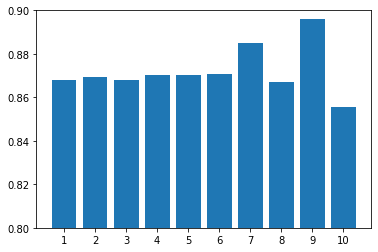

In [209]:
nodes_results = {'1' : 0.8678, '2' : 0.8694, '3' : 0.8681, '4' : 0.8703, "5": 0.8702,'6' : 0.8708,'7' : 0.8852,'8' : 0.8669,'9' : 0.8962,'10' : 0.8554}
# Barplot
plt.bar(*zip(*nodes_results.items()))
plt.ylim(0.8, 0.9)
plt.show()

### the accuracy difference between successive predictions (with the same hyperparamers) can be different by up to several percent

In [0]:
# Number of nodes (epochs = 20, batch_size = 100, momentum = 0.9)

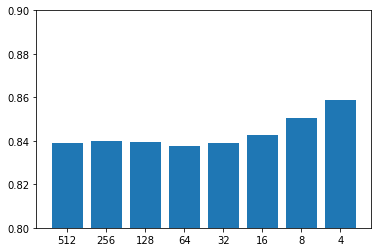

In [63]:
nodes_results = {'512' : 0.8390, '256' : 0.8398, '128' : 0.8393, '64' : 0.8374, "32": 0.8390, '16' : 0.8428, '8' : 0.8503, '4' : 0.8587 }
# Barplot
plt.bar(*zip(*nodes_results.items()))
plt.ylim(0.8, 0.9)
plt.show()

### It looks like number of layers which are near number of classes are best

In [0]:
# Number of epochs (number_of_nodes = 4, batch_size = 100, momentum = 0.9)

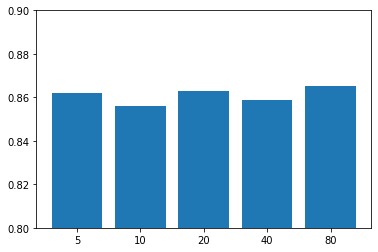

In [90]:
nodes_results = {'5' : 0.8621, '10' : 0.8560, '20' : 0.8630, '40' : 0.8588, "80": 0.8654}
# Barplot
plt.bar(*zip(*nodes_results.items()))
plt.ylim(0.8, 0.9)
plt.show()

### There is no visible correlation between number of epochs and accuracy

In [0]:
# Batch_size (number_of_nodes = 4, epochs = 5, momentum = 0.9)

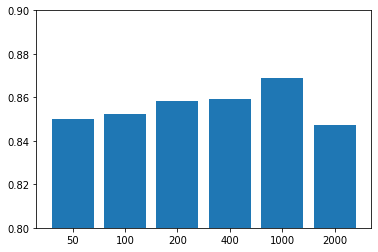

In [122]:
nodes_results = {'50' : 0.8500, '100' : 0.8523, '200' : 0.8584, '400' : 0.8593, "1000": 0.8689, "2000": 0.8471}
# Barplot
plt.bar(*zip(*nodes_results.items()))
plt.ylim(0.8, 0.9)
plt.show()

### It looks like increasing the batch size results in better accuracy, up to some point when it start decreasing again, optimal value is probably somewhere around 1000 smaples

In [0]:
# Momentum (number_of_nodes = 4, epochs = 5, Batch_size = 1000)

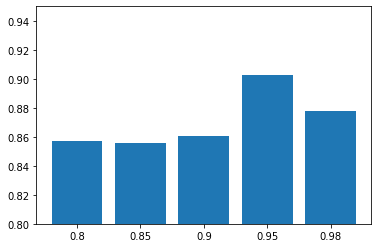

In [164]:
nodes_results = {'0.8' : 0.8571, '0.85' : 0.8554, '0.9' : 0.8606, '0.95' : 0.9028, '0.98': 0.8781}
# Barplot
plt.bar(*zip(*nodes_results.items()))
plt.ylim(0.8, 0.95)
plt.show()

### Results for different momentum are random, it is hard to find any correlation

# Final Conclusions

## It seems that checked values of analyzed parameters have not significant influence on model accuracy. Especially considering the fact, that accuracy strongly depend on model noice